<a href="https://colab.research.google.com/github/RamyaVidiyala/SpamDetectionInEmails/blob/master/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [2]:
data = pd.read_csv("spam.csv",encoding = "'latin'")

In [3]:
data.tail()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ã_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [4]:
data["text"] = data.v2
data["spam"] = data.v1


# Splitting data

In [5]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2)

emails_test.tail()



5292    Urgent! Please call 09061213237 from landline....
2001               Idea will soon get converted to live:)
5056    Hey next sun 1030 there's a basic yoga course....
3953    I probably won't eat at all today. I think I'm...
244                 U don't remember that old commercial?
Name: text, dtype: object

In [6]:
data.info


<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham             Will Ã_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4                             

In [7]:
emails_train.shape


(4457,)

# Preprocessing

In [8]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]


'aight will do thanks again for comin out'

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)


In [10]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

# Tokenize

In [11]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [12]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]


/tmp/ipykernel_247/784444456.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
/tmp/ipykernel_247/784444456.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test_features = np.array(tokenizer.texts_to_sequences(x_test))


[361, 31, 30, 177, 202, 13, 1027, 49]

In [13]:
np.save('x_train.npy', x_train)

# Padding

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([   0,    0,    0, ...,   13, 1027,   49], dtype=int32)

# Model

In [15]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [16]:
# create the model
import tensorflow as tf
from keras.layers import Dense,LSTM, Embedding, Dropout, Activation, Bidirectional

#size of the output vector from each layer
embedding_vecor_length = 32

#Creating a sequential model
model = tf.keras.Sequential()

#Creating an embedding layer to vectorize
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))

#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))

#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))

#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))

#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 32)          1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

In [17]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))


Epoch 1/20
9/9 [==============================] - 8s 468ms/step - loss: 0.6410 - accuracy: 0.8551 - val_loss: 0.5428 - val_accuracy: 0.8547
Epoch 2/20
9/9 [==============================] - 3s 359ms/step - loss: 0.4350 - accuracy: 0.8687 - val_loss: 0.4189 - val_accuracy: 0.8547
Epoch 3/20
9/9 [==============================] - 3s 360ms/step - loss: 0.3659 - accuracy: 0.8687 - val_loss: 0.3722 - val_accuracy: 0.8547
Epoch 4/20
9/9 [==============================] - 3s 361ms/step - loss: 0.3244 - accuracy: 0.8687 - val_loss: 0.3043 - val_accuracy: 0.8547
Epoch 5/20
9/9 [==============================] - 3s 364ms/step - loss: 0.2228 - accuracy: 0.8701 - val_loss: 0.2103 - val_accuracy: 0.8933
Epoch 6/20
9/9 [==============================] - 3s 362ms/step - loss: 0.1566 - accuracy: 0.9549 - val_loss: 0.1759 - val_accuracy: 0.9516
Epoch 7/20
9/9 [==============================] - 3s 360ms/step - loss: 0.1247 - accuracy: 0.9666 - val_loss: 0.1358 - val_accuracy: 0.9758
Epoch 8/20
9/9 [====

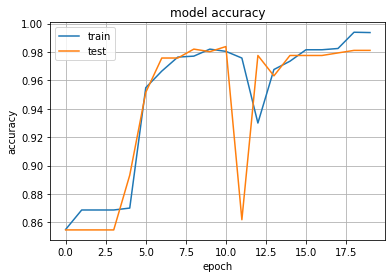

In [18]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [20]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

35/35 [==============================] - 2s 43ms/step


In [21]:
cf_matrix =confusion_matrix(test_y,y_predict)

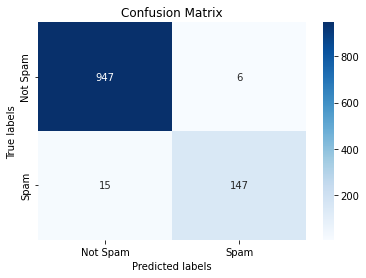

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [23]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [24]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 96.08%
Recall: 90.74%
F1 Score: 93.33%


In [25]:
f1_score(test_y,y_predict)

0.9333333333333333

In [26]:
def preprocess_test_data(sentence):
    sentence_cleaned = clean_up_pipeline(sentence)
    sentence_sequence = np.array(tokenizer.texts_to_sequences([sentence_cleaned]))
    sentence_padded = pad_sequences(sentence_sequence, maxlen=max_len)
    return sentence_padded


In [27]:
def paragraph_prediction(sentence):
    preprocessed_sentence = preprocess_test_data(sentence)
    prediction = model.predict(preprocessed_sentence)
    print(prediction)
    if prediction>0.5:
        return "spam"
    else:
        return "not spam"

In [31]:
message = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
message2 = "Ok lar... Joking wif u oni..."
prediction = paragraph_prediction(message)
print(prediction)

1/1 [==============================] - 0s 60ms/step
[[0.93714607]]
spam


In [29]:
model.save('spam_model3.h5')

In [30]:
import pickle
with open('my_function.pkl', 'wb') as f:
    pickle.dump(paragraph_prediction, f)